<a href="https://colab.research.google.com/github/ysj9909/GANs/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Generative Adverasarial Network**

 * paper link: https://arxiv.org/pdf/1406.2661.pdf
 * code reference : https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/gan/gan.py
 * my paper review : https://blog.naver.com/wsz87/222572167729

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import numpy as np
from torchvision.utils import save_image

In [ ]:
# Hyper-parameters
num_epochs = 200
batch_size = 128
learning_rate = 0.0002
latent_dim = 100
img_size = 28   # MNIST dataset

In [ ]:
train_dataset = torchvision.datasets.MNIST(root = "./data", train = True, download = True,
                                           transform = transforms.Compose([transforms.Resize(img_size),
                                                                           transforms.ToTensor(), 
                                                                           transforms.Normalize([0.5], [0.5])]))

train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True, num_workers = 4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()

    def Block(in_feat, out_feat, normalize = True):
      layers = [nn.Linear(in_feat, out_feat)]
      if normalize : 
        layers.append(nn.BatchNorm1d(out_feat, 0.8))
      layers.append(nn.LeakyReLU(0.2, inplace = True))
      return layers
    
    self.model = nn.Sequential(
        *Block(latent_dim, 128, normalize = False),
        *Block(128, 256),
        *Block(256, 512),
        *Block(512, 1024),
        nn.Linear(1024, img_size **2),
        nn.Tanh()
    )

  def forward(self, z):
    img = self.model(z)
    img = img.view(img.size(0), 1, img_size, img_size)      # (batch_size, 1, 28, 28)
    return img

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.model = nn.Sequential(
        nn.Linear(img_size * img_size, 512),
        nn.LeakyReLU(0.2, inplace = True),
        nn.Linear(512, 256),
        nn.LeakyReLU(0.2, inplace = True),
        nn.Linear(256, 1),
        nn.Sigmoid()
    )
  
  def forward(self, img):
    img = img.view(img.size(0), -1)
    output = self.model(img)
    return output
    

In [ ]:
generator = Generator()
discriminator = Discriminator()
generator.cuda()
discriminator.cuda()

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [ ]:
# Loss and optimizers
adversarial_loss = nn.BCELoss()
adversarial_loss.cuda()
optimizer_G = torch.optim.Adam(generator.parameters(), lr = learning_rate, betas = (0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr = learning_rate, betas = (0.5, 0.999))

In [ ]:
# Train the model
sample_interval = 2000 
for epoch in range(num_epochs):
  for i, (imgs, _) in enumerate(train_loader):
    real_imgs = imgs.cuda()

    z = torch.normal(mean = 0, std = 1, size = (imgs.shape[0], latent_dim)).cuda()
    fake_imgs = generator(z)
    
    # generate labels for real and fake
    real = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(1.0)
    fake = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(0.0)

    # Train Generator
    optimizer_G.zero_grad()
    G_loss = adversarial_loss(discriminator(fake_imgs), real)
    G_loss.backward()
    optimizer_G.step()

    # Train Discriminator
    optimizer_D.zero_grad()
    D_loss = adversarial_loss(discriminator(real_imgs), real) + adversarial_loss(discriminator(fake_imgs.detach()), fake)
    D_loss.backward()
    optimizer_D.step()

    done = epoch * len(train_loader) + i
    if done % sample_interval == 0:
      save_image(fake_imgs[:25], f"{done}.png", nrow = 5, normalize = True)

    if (i + 1) % 100 == 0:
      print(f"Epoch [{epoch + 1} / {num_epochs}], Step [{i + 1} / {len(train_loader)}], Generator Loss : {G_loss.item()}, Discriminator Loss : {D_loss.item()}")


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [1 / 200], Step [100 / 469], Generator Loss : 2.09584903717041, Discriminator Loss : 0.3406221270561218
Epoch [1 / 200], Step [200 / 469], Generator Loss : 2.4983391761779785, Discriminator Loss : 0.5619372725486755
Epoch [1 / 200], Step [300 / 469], Generator Loss : 1.9805865287780762, Discriminator Loss : 0.40672174096107483
Epoch [1 / 200], Step [400 / 469], Generator Loss : 2.2893991470336914, Discriminator Loss : 0.44277501106262207
Epoch [2 / 200], Step [100 / 469], Generator Loss : 1.2466927766799927, Discriminator Loss : 0.6105299592018127
Epoch [2 / 200], Step [200 / 469], Generator Loss : 2.3442912101745605, Discriminator Loss : 0.3991682827472687
Epoch [2 / 200], Step [300 / 469], Generator Loss : 5.255550384521484, Discriminator Loss : 1.7649363279342651
Epoch [2 / 200], Step [400 / 469], Generator Loss : 2.0819334983825684, Discriminator Loss : 0.43060141801834106
Epoch [3 / 200], Step [100 / 469], Generator Loss : 2.6495425701141357, Discriminator Loss : 0.492673963

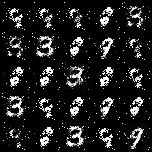

In [ ]:
from IPython.display import Image

Image("10000.png")

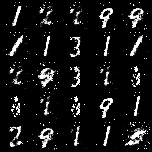

In [ ]:
Image("90000.png")